In [1]:
using Knet
include(Knet.dir("data","gutenberg.jl"))
trn,tst,chars = shakespeare()
# summary(x) returns a string with a brief description. 
# By default returns string(typeof(x)), e.g. Int64.
# mapping applies summary to other arguments to give a
# brief look to variables, doesn't change anything.
map(summary,(trn,tst,chars))

("4934845-element Array{UInt8,1}", "526731-element Array{UInt8,1}", "84-element Array{Char,1}")

In [2]:
# There are 84 unique characters in the data and they are mapped to UInt8 values in 1:84.
# The chars array can be used to recover the original text:
chars[trn][end-97: end - 90]

8-element Array{Char,1}:
 'a'
 'n'
 'd'
 ' '
 't'
 'i'
 'm'
 'e'

In [3]:
BATCHSIZE = 256
SEQLENGTH = 100

function minibatch_rnn(data)
    num_batch = div(length(data), BATCHSIZE)
    # reshape full data to (B,num_batch) with contiguous rows
    # 
    #x = reshape(data[1:num_batch * BATCHSIZE], num_batch, BATCHSIZE)'
    x = reshape(data[1:num_batch * BATCHSIZE], BATCHSIZE, num_batch)
    # split into (B,T) blocks
    # Meaning of : x[:,1:num_batch-1], x[:,2:num_batch]
    # Remember in char-rnn we were feeding next char as, sort of,
    # label to the data. We sample at t, then compare with t+1. Then
    # obtain loss.
    minibatch(x[:,1:num_batch-1], x[:,2:num_batch], SEQLENGTH) 
end

dtrain, dtest = minibatch_rnn(trn), minibatch_rnn(tst)
map(length, (dtrain, dtest))

(192, 20)

In [4]:
RNNTYPE = :lstm  # can be :lstm, :gru, :tanh, :relu
NUMLAYERS = 1    # number of RNN layers
INPUTSIZE = 168  # size of the input character embedding
HIDDENSIZE = 334 # size of the hidden layers
VOCABSIZE = 84   # number of unique characters in data

# To run on GPU, use KnetArray
# d... means varargs, 0 or more arguments
# xavier directly passes varargs to rand in implementation
function initmodel()
    w(d...)=xavier(Float32,d...)
    b(d...)=zeros(Float32,d...)
    # r is rnn struct.
    # w: single weight array that includes all matrices and biases for the RNN
    r,wr = rnninit(INPUTSIZE,HIDDENSIZE,rnnType=RNNTYPE,numLayers=NUMLAYERS)
    # input embedding matrix
    wx = w(INPUTSIZE,VOCABSIZE)
    # wy: hidden state to output
    wy = w(VOCABSIZE,HIDDENSIZE)
    by = b(VOCABSIZE,1)
    return r,wr,wx,wy,by
end

initmodel (generic function with 1 method)

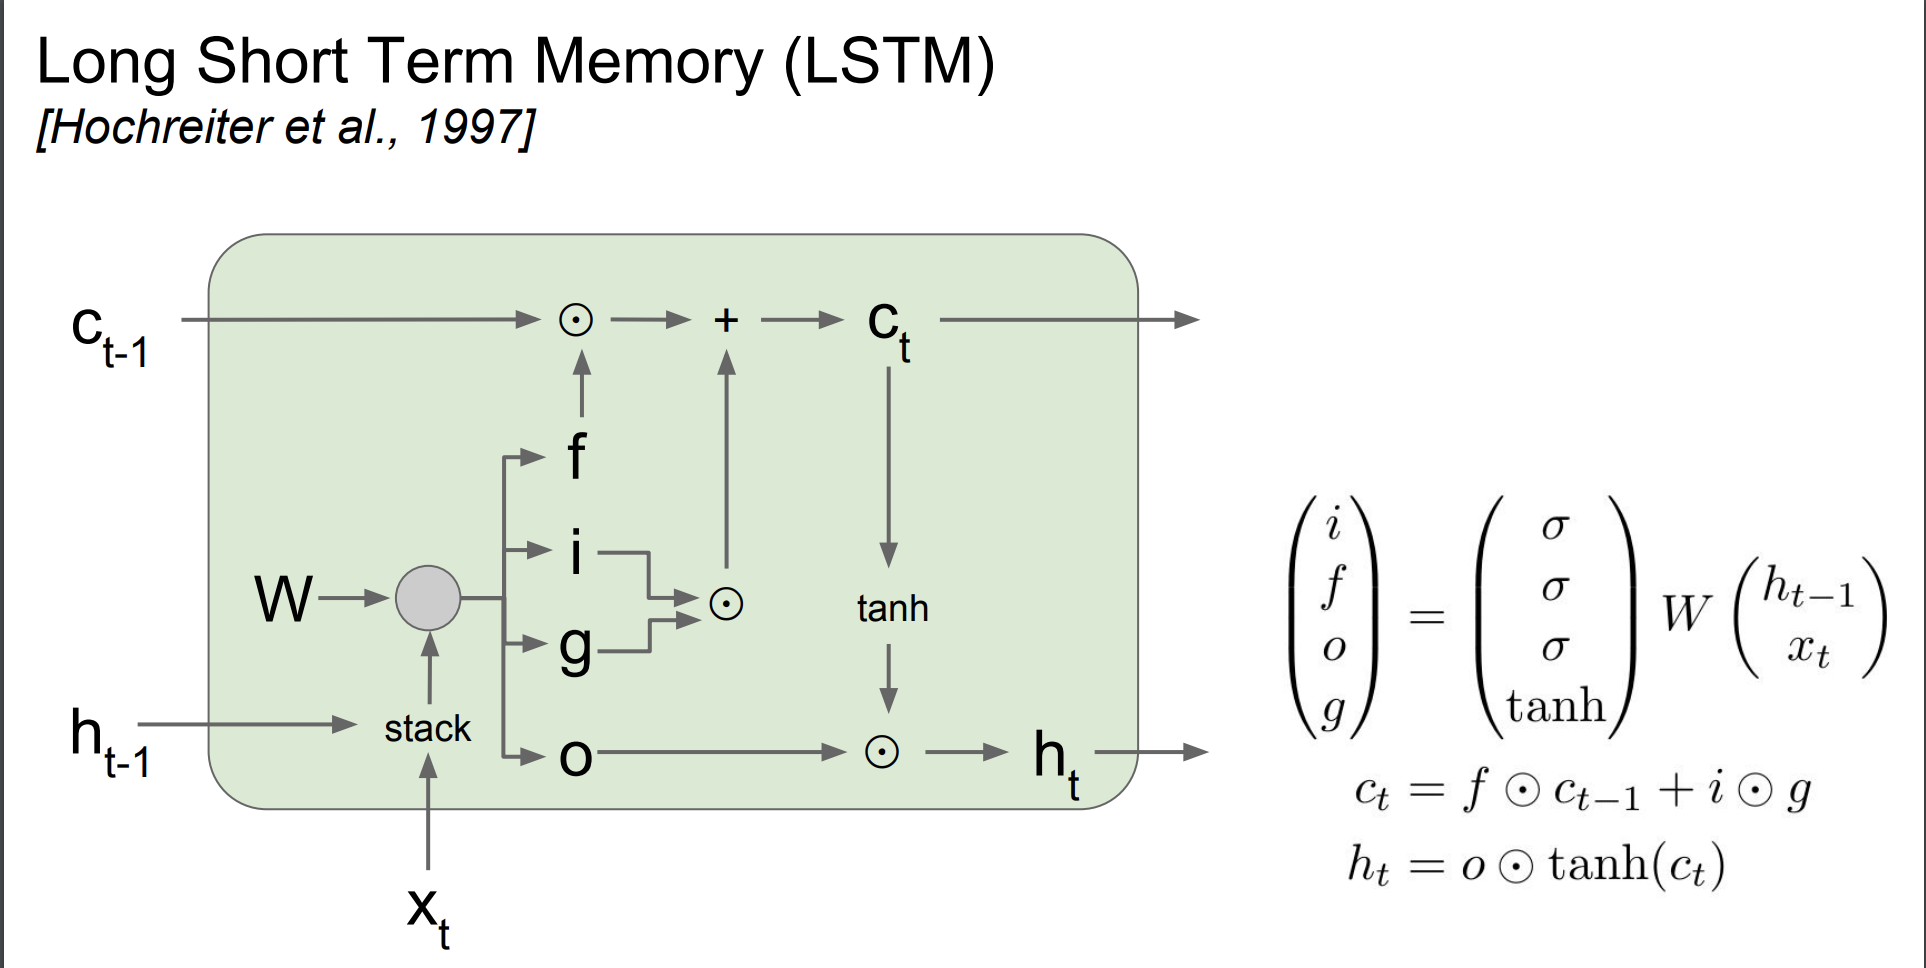

In [5]:
# not fully understood
function predict(ws, xs, hx, cx)
    # ws expected to have this structure
    r,wr,wx,wy,by = ws
    # TODO digest line below
    x = wx[:,xs] # xs=(Batch,Time) x=(X,B,T)
    # y=(H,B,T) hy=cy=(H,B,L)
    y,hy,cy = rnnforw(r, wr, x, hx, cx, hy=true, cy=true)
    ys = by.+wy*reshape(y,size(y,1),size(y,2)*size(y,3)) # ys=(H,B*T)
    return ys, hy, cy
end

predict (generic function with 1 method)

In [6]:
function loss(w, x, y, h)
    # h[1]-> hx, h[2]-> cx
    py, hy, cy = predict(w, x, h...)
    # In order AutoGrad to work we need getval somehow..
    h[1], h[2] = getval(hy), getval(cy)
    return nll(py, y)
end

# reports loss and calculates grads
lossgradient = gradloss(loss)

(::gradfun) (generic function with 1 method)

In [7]:
function train(model, data, optim)
    # rnn forwards assumes zero vector when hidden is nothing
    hiddens = Any[nothing, nothing]
    losses = []
    for (x, y) in data
        grads, current_loss = lossgradient(model, x, y, hiddens)
        update!(model, grads, optim)
        push!(losses, current_loss)
    end
    return mean(losses)
end

function test(model, data)
    hiddens = Any[nothing, nothing]
    losses = []
    for (x, y) in data
        current_loss = loss(model, x, y, hiddens)
        push!(losses, current_loss)
    end
    return mean(losses)
end

test (generic function with 1 method)

In [8]:
# Let's train
EPOCHS = 10
model = initmodel()
optim = optimizers(model, Adam)
@time for epoch in 1:EPOCHS
    @time trnloss = train(model,dtrain,optim) # ~18 seconds
    @time tstloss = test(model,dtest)        # ~0.5 seconds
    println((:epoch, epoch, :trnppl, exp(trnloss), :tstppl, exp(tstloss)))
end

983.938376 seconds (49.50 M allocations: 490.977 GiB, 21.88% gc time)
 38.377965 seconds (2.58 M allocations: 12.148 GiB, 7.83% gc time)
(:epoch, 1, :trnppl, 25.758282f0, :tstppl, 23.529913f0)
891.528233 seconds (44.52 M allocations: 490.720 GiB, 22.46% gc time)
 34.552269 seconds (945.09 k allocations: 12.077 GiB, 8.61% gc time)
(:epoch, 2, :trnppl, 24.428978f0, :tstppl, 23.530243f0)
1108.173357 seconds (44.52 M allocations: 490.720 GiB, 37.96% gc time)
 35.052935 seconds (945.09 k allocations: 12.077 GiB, 8.78% gc time)
(:epoch, 3, :trnppl, 24.41434f0, :tstppl, 23.518257f0)


LoadError: [91mInterruptException:[39m

In [15]:
function generate(model, n)
    function sample(y)
        p, r = Array(exp.(y - logsumexp(y))), rand()
        for j=1:length(p)
            (r -= p[j]) < 0 && return j
        end
    end
    h,c = nothing,nothing
    x = findfirst(chars,'\n')
    for i=1:n
        y,h,c = predict(model,[x],h,c)
        x = sample(y)
        print(chars[x])
    end
    println()
end

generate (generic function with 1 method)

__I've trained for a very short time, it's no surpise that it did not converged.__

In [16]:
generate(model,1000)

tl'U4donsenooro cah,oien
 s.A  ,ina ih tprwt m  eeh  iLr gs  l o?d
resw  itetlhaeOyo
t hd
 e   ret,lr  a  en
IuepuoaetOo enRpovhh it  s bictcEHdn.e
  mnot  hi
uyb  rhs   Rredott.svR at
 shO ldN Uaogb saatone W s,o   hhpsors  dTdia  t oo 
I.wYn  attnmoei h  wt eaTwO Tnn.  g s 
nYbibtirtsr narljs A
orloekoa a
 R
Ciosioe c ntbc i  moeeoU  a  d HTIf, t
sot, aO,loe y ! dAod  hOgas nhe lopAyeeafewra eedteD oos  m
dt w  t.IBe w acefatona   t  e set yh o s wuotae!sy t oh dtep
rsvcnh uorA  Iiaen teab d tTf h H  tg y Ed.rsnm' a l ns
hcM: ie f i loT  lywet  tefDhli c efM h  d li;    d
 si
ini; ch,w
n AiTn mhV tn do obs
urRua knAye 
ct wwairh TL q .hsAwFpA t IooHpsNr Seg xh nt nngshuho  t  soUo  aHbs e gnh sg as'.isrTKdn
Wi  biEnhooneA fSossmcoo  d e,oInoeii tAEml.orOd i , 
Adra lT  E.m ss  Se'he w
